In [1]:
%matplotlib inline

Dependency: `healpy`, `pymaster`, `xarray`, `pandas`, `seaborn`

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
import glob,gc,os

In [3]:
# The computation of polarized power spectra using the pure-E and B approach
def get_field(filename, mask):
    f_0 = nmt.NmtField(mask, [hp.read_map(filename, field=0, verbose=False)])
    f_2 = nmt.NmtField(mask, hp.read_map(filename, field=[1, 2], verbose=False), purify_e=True, purify_b=True)
    return f_0, f_2

def get_cl(filename, mask, b, wsp):
    f_0, f_2 = get_field(filename, mask)
        
    # Compute MASTER estimator
    # spin-0 x spin-0 = TT
    TT, = nmt.compute_full_master(f_0, f_0, b, workspace=wsp[0])
    # spin-0 x spin-2 = TE, TB
    TE, TB = nmt.compute_full_master(f_0, f_2, b, workspace=wsp[1])
    # spin-2 x spin-2 = EE, EB, BE, BB
    EE, EB, BE, BB = nmt.compute_full_master(f_2, f_2, b, workspace=wsp[2])
    return TT, EE, BB, TE, TB, EB

In [22]:
# Information for TIGRESS synthetic maps
# dust polarization maps at 353 GHz can be downloaded at https://lambda.gsfc.nasa.gov/simulation/tb_tigress_data.cfm
data_folder = '../data/allsky_maps/'

# 9 observer positions
observers = ['x0y0z0','x-256y0z0','x256y0z0',
             'x0y-256z0','x-256y-256z0','x256y-256z0',
             'x0y256z0','x-256y256z0','x256y256z0']

# 350 snapshots to process
itimes=np.arange(300,650,dtype=int)

In [23]:
# Setup mask

# HEALPix map resolution
nside = 128

# Let us first create a mask:
Nmsk = np.ones(hp.nside2npix(nside))
Smsk = np.ones(hp.nside2npix(nside))
th, ph = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
# for |b| > 30deg
Nmsk[np.where((th > np.pi/3))[0]] = 0.
Smsk[np.where((th < 2*np.pi/3))[0]] = 0.

# Now we apodize the mask. The pure-B formalism requires the mask to be
# differentiable along the edges. The 'C1' and 'C2' apodization types
# supported by mask_apodization achieve this.
Nmsk_apo = nmt.mask_apodization(Nmsk, 10.0, apotype='C1')
Smsk_apo = nmt.mask_apodization(Smsk, 10.0, apotype='C1')

# Select a binning scheme
# We use the same binning window size used in Kim et al. 2019
bincenters = np.array([35, 80, 200])
binwidths = np.array([15, 40, 200])
binleftedge = bincenters - binwidths/2.
binrightedge = bincenters + binwidths/2.
binleftedge = np.array(binleftedge, dtype=np.int_)
binrightedge = np.array(binrightedge, dtype=np.int_)
b = nmt.NmtBin.from_edges(binleftedge, binrightedge, is_Dell=True)

leff = b.get_effective_ells()

# Workspace initialization for the same mask
filename=glob.glob('{}*.fits'.format(data_folder))[0]
f0, f2 = get_field(filename,Nmsk_apo)
Nwsp_00 = nmt.NmtWorkspace()
Nwsp_00.compute_coupling_matrix(f0, f0, b)
Nwsp_02 = nmt.NmtWorkspace()
Nwsp_02.compute_coupling_matrix(f0, f2, b)
Nwsp_22 = nmt.NmtWorkspace()
Nwsp_22.compute_coupling_matrix(f2, f2, b)
Nwsp = [Nwsp_00,Nwsp_02,Nwsp_22]

f0, f2 = get_field(filename,Smsk_apo)
Swsp_00 = nmt.NmtWorkspace()
Swsp_00.compute_coupling_matrix(f0, f0, b)
Swsp_02 = nmt.NmtWorkspace()
Swsp_02.compute_coupling_matrix(f0, f2, b)
Swsp_22 = nmt.NmtWorkspace()
Swsp_22.compute_coupling_matrix(f2, f2, b)
Swsp = [Swsp_00,Swsp_02,Swsp_22]

/Users/ckim/miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/Users/ckim/miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


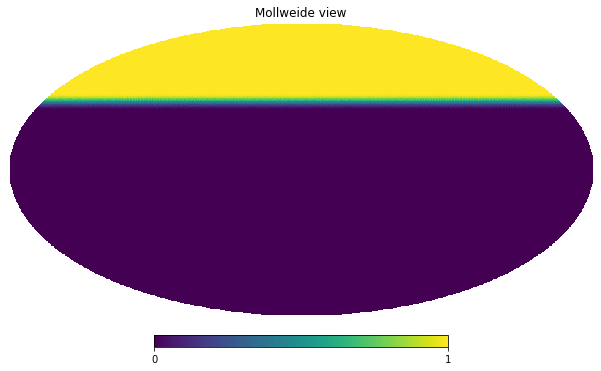

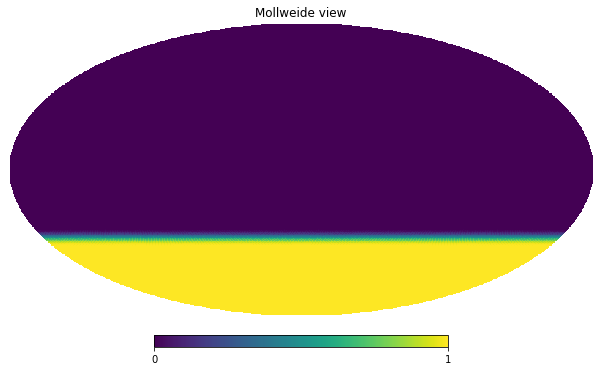

In [24]:
hp.mollview(Nmsk_apo)
hp.mollview(Smsk_apo)

In [25]:
# pandas and xarray are used to store data
import pandas as pd
import xarray as xr

# Calculate Cl and store into files
override = True
for j,obs in enumerate(observers):
    Nfout = '../data/{}.b30.rebin.N.cls.nc'.format(obs)
    Sfout = '../data/{}.b30.rebin.S.cls.nc'.format(obs)
    if (not os.path.isfile(Nfout)) or override:
        print(obs)
        Ncl_time = []
        Scl_time = []
        for i in itimes:
            if (i%10 ==0): print(i)
            filename='{}MHD_4pc_new.{:04d}.Nside128-{}.fits'.format(data_folder,i,obs)
            # North
            cls = get_cl(filename,Nmsk_apo,b,Nwsp)
            Ndf = pd.DataFrame(np.array(cls).T,index=leff,columns=['TT','EE','BB','TE','TB','EB'])
            Nda = Ndf.to_xarray().rename(index='leff').assign_coords(time=i)
            Ncl_time.append(Nda)
            # South
            cls = get_cl(filename,Smsk_apo,b,Swsp)
            Sdf = pd.DataFrame(np.array(cls).T,index=leff,columns=['TT','EE','BB','TE','TB','EB'])
            Sda = Sdf.to_xarray().rename(index='leff').assign_coords(time=i)
            Scl_time.append(Sda)
        dset=xr.concat(Ncl_time,dim='time').assign_coords(observer=j)
        dset.to_netcdf(Nfout)
        dset.close()
        dset=xr.concat(Scl_time,dim='time').assign_coords(observer=j)
        dset.to_netcdf(Sfout)
        dset.close()

x0y0z0
300


/Users/ckim/miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
x-256y0z0
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
x256y0z0
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
x0y-256z0
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
x-256y-256z0
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
x256y-256z0
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
x0y256z0
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
5

In [26]:
# save a concanated data into a single file
dlist = []
for obs in observers:
    fout = '../data/{}.b30.rebin.N.cls.nc'.format(obs)
    if os.path.isfile(fout):
        with xr.open_dataset(fout) as dset:
            dlist.append(dset)

dset = xr.concat(dlist,dim='observer')
dset.to_netcdf('../data/all_cls.b30.rebin.N.nc')
dset.close()

# save a concanated data into a single file
dlist = []
for obs in observers:
    fout = '../data/{}.b30.rebin.S.cls.nc'.format(obs)
    if os.path.isfile(fout):
        with xr.open_dataset(fout) as dset:
            dlist.append(dset)

dset = xr.concat(dlist,dim='observer')
dset.to_netcdf('../data/all_cls.b30.rebin.S.nc')
dset.close()